### [예제 11.1] MLPClassifier의 최적화 알고리즘 비교하기

In [1]:
import warnings
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
%matplotlib inline
warnings.filterwarnings("ignore")

iris = datasets.load_iris()
X_digits, y_digits = datasets.load_digits(return_X_y=True)
data_sets = [(iris.data, iris.target), (X_digits, y_digits),
             datasets.make_circles(noise=0.2, factor=0.5, random_state=1),
             datasets.make_moons(noise=0.3, random_state=0)]

In [2]:
labels = ["constant learning-rate", "inv-scaling learning-rate", "adam"]
params = [{
    "solver": "sgd",
    "learning_rate": "constant",
    "momentum": 0,
    "learning_rate_init": 0.2
}, {
    "solver": "sgd",
    "learning_rate": "invscaling",
    "momentum": 0,
    "learning_rate_init": 0.2
}, {
    "solver": "adam",
    "learning_rate_init": 0.01
}]

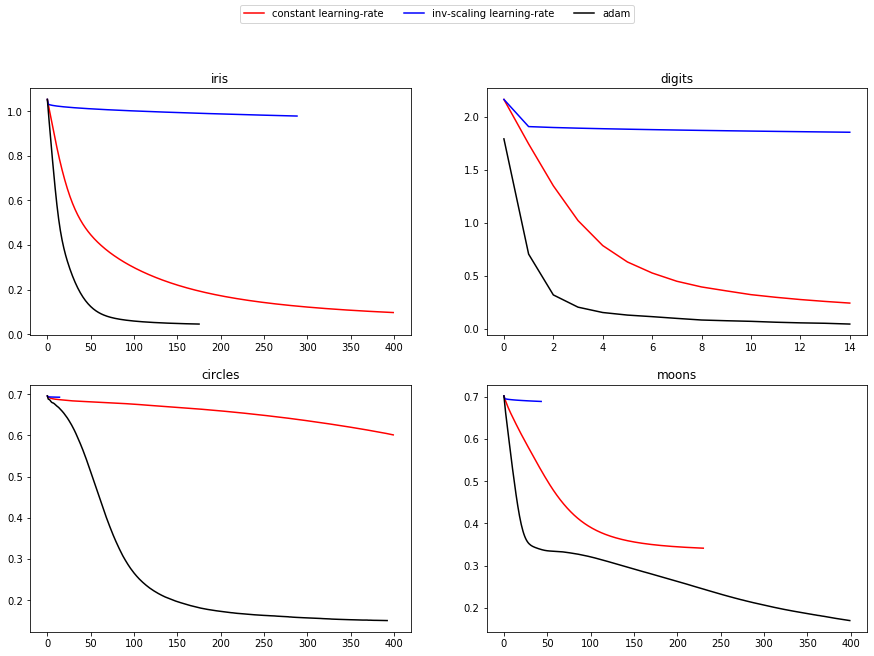

In [3]:
plot_args = [{
    "c": "red",
    "linestyle": "-"
}, {
    "c": "blue",
    "linestyle": "-"
}, {
    "c": "black",
    "linestyle": "-"
}]


def plot_on_dataset(X, y, ax, name):
    ax.set_title(name)

    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits": max_iter = 15
    else: max_iter = 400

    for label, param in zip(labels, params):
        mlp = MLPClassifier(random_state=0, max_iter=max_iter,
                            **param).fit(X, y)
        mlps.append(mlp)

    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, data, name in zip(axes.ravel(), data_sets,
                          ["iris", "digits", "circles", "moons"]):
    plot_on_dataset(*data, ax=ax, name=name)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

## 11 되새김 문제

### [되새김 문제 11.1] MLPClassifier 클래스 적용하기

#### 문제

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X, y = load_breast_cancer(return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=1234)

#### 풀이

In [5]:
from sklearn.metrics import recall_score

clf = MLPClassifier(hidden_layer_sizes=(20, 10),
                    solver='adam',
                    max_iter=1000,
                    random_state=1234,
                    early_stopping=True)

y_pred = clf.fit(X_train, y_train).predict(X_test)

print(f'테스트셋 재현율:{recall_score(y_test, y_pred) * 100: .2f}%')

테스트셋 재현율: 91.43%


### [되새김 문제 11.2] 최적의 지도 학습 모델 탐색하기

#### 문제

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=1234)

#### 풀이

In [7]:
import numpy as np
from sklearn.pipeline import Pipeline
import time
import warnings

warnings.filterwarnings("ignore")

scaler = StandardScaler()

logistic = LogisticRegression(max_iter=10000, tol=0.1, random_state=1234)
DT = DecisionTreeClassifier(random_state=1234)
RF = RandomForestClassifier(random_state=1234, n_estimators=200)
KNN = KNeighborsClassifier()
svc = SVC(random_state=1234)
mlp = MLPClassifier(random_state=1234)

logistic_param_grid = {
    'logistic__penalty': ['l1', 'l2', 'elasticnet'],
    'logistic__C': np.logspace(-4, 4, 4)
}
DT_param_grid = {
    'DT__max_depth': range(1, 6),
    'DT__ccp_alpha': np.logspace(-6, 2, 8)
}
RF_param_grid = {'RF__max_depth': [9, 10, 11]}
KNN_param_grid = {'KNN__n_neighbors': [2 * x + 1 for x in range(1, 10)]}
svc_param_grid = {
    'svc__C': np.logspace(-4, 4, 4),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(30, ), (20, 20), (10, 10, 10)],
    'mlp__solver': ['lbfgs', 'sgd', 'adam']
}

search_space = [['logistic', logistic, logistic_param_grid],
                ['DT', DT, DT_param_grid], ['RF', RF, RF_param_grid],
                ['KNN', KNN, KNN_param_grid], ['svc', svc, svc_param_grid],
                ['mlp', mlp, mlp_param_grid]]

for s in search_space:
    start_time = time.time()
    pipe = Pipeline(steps=[("scaler", scaler), (s[0], s[1])])
    search = GridSearchCV(pipe, s[2])
    search.fit(X, y)

    print(f'모델: {s[0]}, 소요 시간: {time.time() - start_time:.3f}초, 탐색 결과: {search.best_params_}, CV 점수: {search.best_score_:.3f}')

모델: logistic, 소요 시간: 2.386초, 탐색 결과: {'logistic__C': 0.046415888336127774, 'logistic__penalty': 'l2'}, CV 점수: 0.923
모델: DT, 소요 시간: 4.749초, 탐색 결과: {'DT__ccp_alpha': 0.0026826957952797246, 'DT__max_depth': 5}, CV 점수: 0.629
모델: RF, 소요 시간: 23.586초, 탐색 결과: {'RF__max_depth': 11}, CV 점수: 0.939
모델: KNN, 소요 시간: 2.469초, 탐색 결과: {'KNN__n_neighbors': 3}, CV 점수: 0.945
모델: svc, 소요 시간: 25.631초, 탐색 결과: {'svc__C': 21.54434690031882, 'svc__kernel': 'poly'}, CV 점수: 0.952
모델: mlp, 소요 시간: 95.920초, 탐색 결과: {'mlp__hidden_layer_sizes': (30,), 'mlp__solver': 'adam'}, CV 점수: 0.927


In [8]:
clf = SVC(C=21.54434690031882, kernel='poly',
          random_state=1234).fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'테스트셋 정확도:{(y_pred == y_test).mean() * 100: .2f}%')

테스트셋 정확도: 98.89%
